In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import math
import time
import calendar
import nltk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import en_core_web_sm
from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor
import operator
import string
import re
# Set seaborn theme
sns.set_theme(style="whitegrid")
from tqdm import tqdm, trange
# Download nltk resources if needed
# nltk.download()

import nltk
import contractions
from nltk.stem import WordNetLemmatizer 
from nltk import sent_tokenize, word_tokenize

# Remove Stopwords 
stop_en=stopwords.words("english")

# Define regex patterns and load NLP model
string_pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
url_pattern = re.compile(r'https?://\S+|www\.\S+')
nlp = en_core_web_sm.load()

# # Define a function to preprocess text
# def preprocess_text(text):
#     text = url_pattern.sub('', text)  # Remove URLs
#     text = string_pattern.sub('', text)  # Remove punctuation
#     text = ' '.join([word.lower() for word in text.split() if word not in stopwords.words('english')])  # Lowercase and remove stopwords
#     return text

# # Define a function to generate word clouds
# def generate_wordcloud(text):
#     wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
#     plt.figure(figsize=(8, 8), facecolor=None)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.tight_layout(pad=0)
#     plt.show()

# # Define a function to summarize text
# def summarize_text(text, num_sentences=3):
#     # Initialize the auto summarization module
#     auto_abstractor = AutoAbstractor()
#     # Set tokenizer
#     auto_abstractor.tokenizable_doc = SimpleTokenizer()
#     # Set summarizer
#     auto_abstractor.summarizable_doc = TopNRankAbstractor()
#     # Summarize text
#     result = auto_abstractor.summarize(text, num_sentences)
#     return ' '.join(result)

# # Define a function to plot a bar chart from a counter object
# def plot_counter(counter_obj, title='', xlabel='', ylabel=''):
#     sorted_counts = sorted(counter_obj.items(), key=operator.itemgetter(1), reverse=True)
#     x, y = zip(*sorted_counts)
#     plt.figure(figsize=(10, 6))
#     plt.bar(x, y)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=90)
#     plt.show()


In [11]:
# set display options for pandas dataframes

pd.options.display.max_columns=2000
pd.options.display.max_rows=2000
pd.options.display.max_colwidth=10000
pd.options.display.max_seq_items=2000

# read in three CSV files into pandas dataframes
df_news_true=pd.read_csv('data/DataSet_Misinfo_TRUE.csv',index_col=False)
df_news_fake=pd.read_csv('data/DataSet_Misinfo_FAKE.csv')
df_news_rpsub=pd.read_csv('data/EXTRA_RussianPropagandaSubset.csv')

In [ ]:


# Initialize an empty DataFrame
df = pd.DataFrame()

# Create a new column 'text' in the empty DataFrame
df['text'] = df_news_true['text']

# Remove punctuation from the text
translator = str.maketrans("", "", string.punctuation)
df['text_new'] = df['text'].map(lambda x: x.translate(translator) if pd.isna(x) == False else '')

# Remove any Unicode characters from the text
df['text_new'] = df['text_new'].map(lambda x: x.encode('ascii', 'ignore').decode("utf-8"))

# Remove any URLs from the text using regular expressions
df['text_new'] = df['text_new'].map(lambda x: re.sub(r"http\S+", "", x))

# Remove any extra spaces in the text
df['text_new'] = df['text_new'].map(lambda x: re.sub(r"\s+", " ", x))

# Convert all text to lowercase
df['text_new'] = df['text_new'].map(lambda x: x.lower())

# Fix contractions in the text using the contractions library
df['text_new'] = df['text_new'].map(lambda sentence: contractions.fix(sentence))

# Lemmatize the text using the WordNetLemmatizer from the nltk library
lemmatizer = WordNetLemmatizer()
df['text_new'] = df['text_new'].map(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(sentence)]))
df['text_new'] = df['text_new'].map(lambda sentence: ' '.join([lemmatizer.lemmatize(w, pos='v') for w in nltk.word_tokenize(sentence)]))


In [27]:
len(df['text_new'])

34975

In [29]:
# Create a new column 'text_new_lemm' by applying the spaCy library's lemmatization function to each row of the 'text_new' column
lemmatization_func = lambda x: [i for i in [(j.lemma_) for j in nlp(x)] if not i in stop_en]

df['text_new_lemm'] = df['text_new'].map(lemmatization_func)

In [30]:
# Combine the lemmatized words into strings
list_sent = [(' ').join(i) for i in df['text_new_lemm'] if len(i) > 1]

In [34]:
# Create a new column 'text_new_pos' by applying the spaCy library's part-of-speech tagging function to each row of the 'text_new' column

pos_func=lambda x: [i for i in [(j.text,j.pos_) for j in nlp(x)] if not i in stop_en]
df['text_new_pos'] = df['text_new'].map(pos_func)

0it [1:12:50, ?it/s]


158237


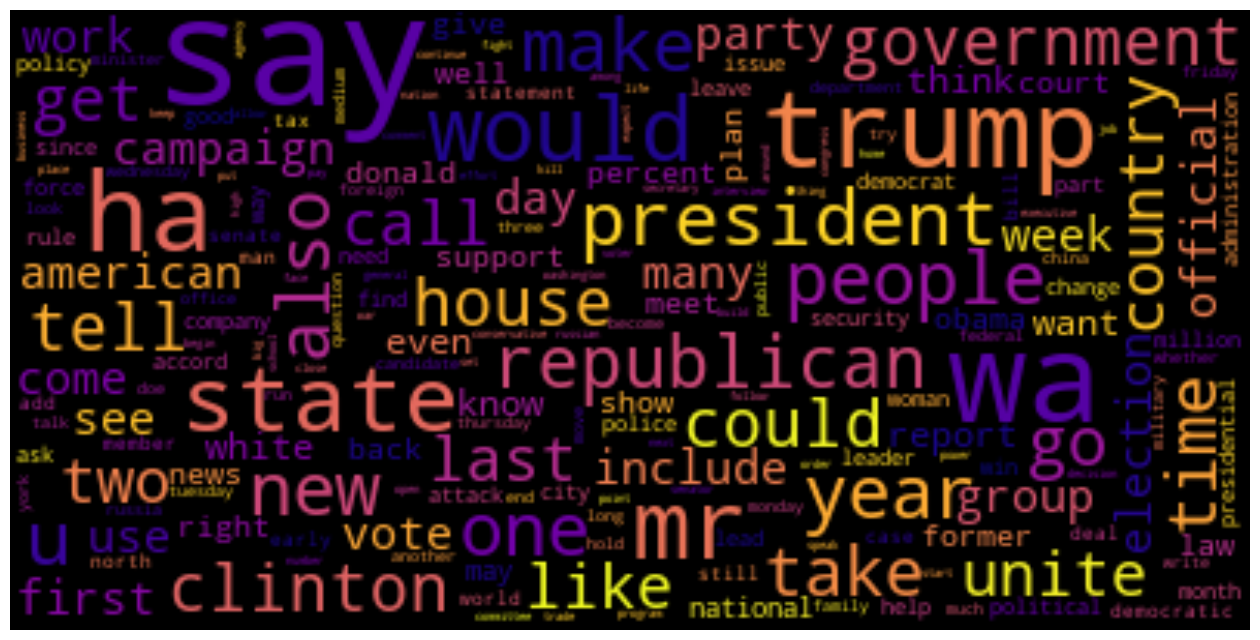

,0
head,7210
conservative,8587
republican,34808
faction,662
u,44380
...,...
lapsset,1
hogendoorn,1
inassistance,1
safejeb,1


In [35]:
# Combine the list of sentences into a single string
sent_exp = [''.join(list_sent)]

# Generate a frequency distribution of the words in the string using NLTK
word_freq = nltk.FreqDist(nltk.word_tokenize(str(sent_exp[0])))

# Remove pronouns from the frequency distribution
list_ = [i for i in word_freq if 'PRON' in i]
for i in list_:
    word_freq.pop(i, None)

# Display the number of unique words in the frequency distribution
print(len(word_freq))

# Generate a word cloud visualization from the frequency distribution using the WordCloud library
cloud = WordCloud(max_font_size=50, colormap='plasma').generate_from_frequencies(word_freq)
plt.figure(figsize=(16, 12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Display the frequency distribution in a DataFrame
pd.DataFrame([word_freq]).T


In [44]:
##############################################
# Plot a Co-Occurrence Matrix
##############################################

# Frequency distribution in a DataFrame

df_word_freq=pd.DataFrame([word_freq]).T
df_word_freq=df_word_freq.reset_index()
df_word_freq.columns=['word','word_freq']
df_word_freq=df_word_freq.sort_values('word_freq', ascending=False)

# Top 30 of the most frequent words
print(list(df_word_freq[:30].word))

# Creating the Co-Occurrence Matrix in the unque 34,941 list of sentences
print(len(list_sent))
def matrix(text, cast):
    mtx = []
    for first in cast:
        row = []
        for second in tqdm(cast):
            count = 0
            for chapter in text:
                for sent in sent_tokenize(chapter):
                    if first in sent and second in sent:
                        count += 1
            row.append(count)
        mtx.append(row)
    return mtx


['say', 'wa', 'trump', 'ha', 'mr', 'state', 'would', 'president', 'u', 'year', 'one', 'people', 'new', 'make', 'republican', 'also', 'time', 'take', 'go', 'house', 'could', 'government', 'clinton', 'tell', 'unite', 'last', 'country', 'two', 'like', 'call']
34941


In [47]:
# First make the matrices
# By frequency
cast=list(df_word_freq[:30].word)
mtx = matrix(list_sent,cast)
mtx

100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


[[31564,
  28530,
  13980,
  28726,
  6106,
  21794,
  19317,
  20308,
  31563,
  17071,
  21061,
  14498,
  19410,
  17518,
  9840,
  16322,
  14906,
  15944,
  24644,
  11717,
  13250,
  11706,
  4621,
  15876,
  11118,
  14200,
  11845,
  14189,
  12750,
  15671],
 [28530,
  30836,
  13854,
  28678,
  6275,
  21406,
  19197,
  19889,
  30834,
  17424,
  21528,
  14645,
  19679,
  17805,
  9854,
  16633,
  15408,
  16306,
  24822,
  11578,
  13434,
  11563,
  4759,
  15684,
  11027,
  14456,
  11842,
  14391,
  13182,
  15906],
 [13980,
  13854,
  15173,
  13823,
  3093,
  11058,
  9955,
  14180,
  15173,
  7519,
  10272,
  6926,
  10101,
  9006,
  7842,
  8110,
  7597,
  7901,
  11798,
  7434,
  6684,
  4971,
  4007,
  7879,
  6365,
  6778,
  5870,
  6540,
  6791,
  8054],
 [28726,
  28678,
  13823,
  31181,
  6293,
  21564,
  19317,
  20012,
  31176,
  17603,
  21665,
  14695,
  19799,
  17963,
  9983,
  16774,
  15458,
  16354,
  25011,
  11658,
  13513,
  11756,
  4804,
  15641,


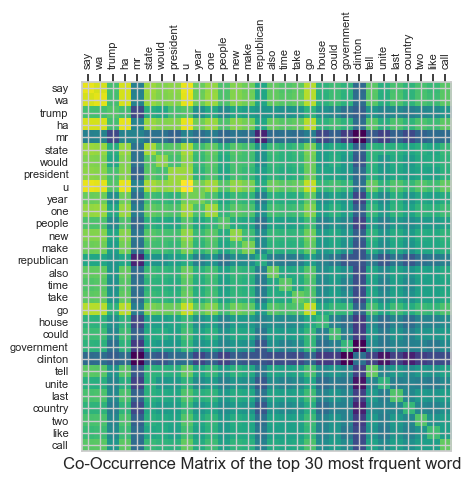

In [55]:
# Now create the plots
fig, ax = plt.subplots()
# fig.suptitle('Co-Occurrence Matrix of the top 30 most frquent words', fontsize=12)
fig.subplots_adjust(wspace=2)

n = len(cast)
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n)


ax.set_xticks(x_tick_marks)
ax.set_yticks(y_tick_marks)
ax.set_xticklabels(cast, fontsize=8, rotation=90)
ax.set_yticklabels(cast, fontsize=8)
ax.xaxis.tick_top()
ax.set_xlabel("Co-Occurrence Matrix of the top 30 most frquent words")
plt.imshow(mtx, norm=matplotlib.colors.LogNorm(), interpolation='nearest', cmap='viridis')

plt.show()